# Demo - Probabilistic Fourier with AR model on coefficients

This file provides an demo of the probabilistic Fourier framework as outline in "Bayesian spectrum estimation of unevenly sampled data" - Qi et al.

$$ {\bf{s}}_t = {\bf{s}}_{t-1} + {\bf{w}}_t $$
$$ {\bf{y}}_t = C^\top {\bf{s}}_t + {\bf{v}}_t $$

## Load packages and functions

In [1]:
using ForneyLab       # based on last official release
using LinearAlgebra
using Plots
using PyPlot
using ProgressMeter
using Compat
using WAV
using Base64
using FileIO
using HDF5
using FLAC
using DSP
using FFTW
using LAR
using LAR.Node
using Distributions

include("../functions/auxiliary/buffer.jl")
include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/workflow.jl")
include("../functions/auxiliary/fourier.jl")
;

## Settings

In [2]:
# data loading
sound_file = "../data/airco.wav"   # specify sound location
fs_desired = 8000                  # specify desired sampling frequency

# input buffer parameters
step_size = 30                      # specify step size of buffer
buffer_size = 30                    # specify size of buffer

# probabilistic fourier parameters 
var_observation = 1e-3               # specify observation noise var
freq_bins = 15
freq = collect(fs_desired/(2*(freq_bins+1)):fs_desired/(2*(freq_bins+1)):(fs_desired/2-fs_desired/(2*(freq_bins+1))))

# AR modelling
AR_order = 2
iterations = 5
;

## Load data

In [3]:
# load and process speech signal
x_time, fs_time = wavread(sound_file, format="native")
fs_time = Int(fs_time)
x_time = x_time[1*fs_time+1:4*fs_time]
x_time = resample(x_time, fs_desired/fs_time)
x_time = 100*x_time/var(x_time)
x_time_clean = x_time
x_time = x_time_clean + rand(Distributions.Normal(0, sqrt(var_observation)), length(x_time_clean))

# specify time axis
t = collect((1:length(x_time))/fs_desired)

# create audioplayer
audioplayers(x_time, fs=fs_desired)
;

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQCNaYs+/B0bPyJkKz+GbT4/OA9GPw0tSD8BU3w/BgGOP82Nkj8DpoI/5fRbP1QCRz/5ykI/KBBpPwv/SD+590I/BTkmP7P2Cz+8fBw/rX8xP7X7HD+mAwI/WjrsPiGalD7STbo+VE1nPn44x71GFNa+6IH1vjcGj74YX889d1FKPlJUlr08GXK+kZ3UvpshdL4DkgK+on26vtjilr47YQu/+01LvwSJfb9T4Vu/RDkQv+LIEr9UdgG/XIgpv5BcPr/DZEu/1VGBvzeRib/ZP4G/+hGQv6y+dr/e8De/IlLOvo8hBr/ryB+/4pUov6J8A79sWuO+mZMlvhL63L3frDG9X3Ftvmj/D7//0y2/sFnfvsq28Lyo9BE+lL96PVvQQL5Jpoa92S87PovoBT+HC+Y+nCTNPjEkCD5j9Qo+qiMlP6/cdD+IrYg/CKVZP6pLHz8QiDI/3YOHP+m8sD/s/6I/TwqPPx97oT9eua4/dwTAPx7bpT9UkYY/5Jx4Px2ecD/gJ24/8zJtP0+3Jj/o0AQ/3JAdP0J0Pz+0JS0/x/yMPgGDdb37YBG9Xm5YPejEZj4lOBW7mTegvoqfQb9vsmq/k0M1v7alz748L/K+qxg7vytOVb8npmy/0qJ0vzvtZL/pFGq/V+5Pvz4ZQ7/YhTq/aj0+vy1XPr/NVvO+dj8PvxF++76eQ9u+nJoLv1DDA7/FYva+AFYPv6/XBb8gpOu+KnDqvtQdu75/xo2+xkc0v7tljb9kh5+/+FSPv/vhVb/O9OS+sOrcvh/04r5OTEu/grtGv0pLQr+P8he/wazNviIykL5lZnq+q8ZOvv3gLL72uA2+/P0QPcXizj68Jik/3+tWP6DIPT8bhRw/qhQvP5MXTD8C3ow/9BqvP/9xqz/moo8/vtiCP9FBhT+IKLM/lc/IP7Kooj/MdIQ/WSk7P998Lz8++z0/IHGLP8IFvT9C2ME/FQizP4ezjD/yXIA/sqdvP3otZz8+s1w/tHImP36B0T6oX8Y+UJO7PmcFiz5MnOU8fLFdvvpq4L68YPO+m7HnvtjEEb8aC0m/kGKPv8Rcr7+W4ZW/tBeJv+v+f7+Z2JW/Sziov9xsu7+YhrW/3Sebv6dDor/L6qq/3qWVv8a5hr9UFFu/f19lv2uAZr/lTVu/CF8zvxPlFb+hcBS/YZEXv3XF8r5IYqe+Orq6vkirtL4KxqW+kPovvo5U176Md7S9b0UfPjaxZz6zFhC82AZ4vuNek705fNS9H9kAPheJ+T56j+Q+NDXaPck5DDz1nSw+LDX7PsNdQj9KhHM/XQ5eP/S2ND8MKkM/OIFRP9fNZT+QY2M/UCVPP54FNj+guB0/lCgFP1QsRT8tEzw/uhppP6tuST/xLj0/ijQQPxJ1qT6xSVc+bW7aPqgNCj/J8D4/2YslP6tY1D7FOUQ+sxhAPhbwAz95myw/Qao+P/4xGz8cdCs9enaTPYNmPj6HAmI+BgHNPXfoyr32qgO+7mP0vXu3GTyYBcs8KdDXvebCoL7jp+m+eV3svqdoib7mogG/W+eBv6d3gr/cipW/1cmMv1Uvfr/9b46/V7O3v17l0r/4O72/b7Gwv7/vlL/PdYC/gWCcv7h0mL+3WW6/kPj8vjszxr7JTty+gbu3vspnVr4zYko9xVoPPvo2Tz5xTZw+ABKyPviNIz+cZB0/38/1PnhZpD7Big0+4LYpPtXiMT9qZlU/JiJAP++p/z4kPCc+TRrnPeljPz6jjiA/SmseP546DD9E594+k0cMP/cHHT/4hlA/AIlbP8/4Wz/bZg8/dcC8Psl5FT+80z8/QW9kP2W5Qz8KwiA/PkH5PioS8j730xg/WLQKP31V8z7N+IQ+05KMPrHAnj6J7no+78mBPmCchT6yBYw+SaQVPmu2lj06Kxs+8hGKPGQQT74nk42+LRP5vTfBH750DYi9fmS1vDCZkr4L9ce+f0gEv7uXxb49Bma+C8HLvhkqQr9v9We/UBtyv14lkr80Q3u/Udt+v06vg7/WdYe/HiCZvx0Hsb91vuS/yw33v0rf378Opc6/Qa+tv1a9or9CWZm/zu+Vv2/Wfb90emG/tscev3nbp76V33C+GMwgvq+yiD41fgU/UXxbP6bBhD9mpVg/k3EsP8hkPz+8r1M/UYaAP6CDqD81lKM/m3SYPyxjfj9ZHnY/kSWfP6Dynz/NlpQ/zb14P4PNdD/zP4w/9HiWPxWWhj+Tv2w/buowPycuQT8yDTI/eXBPP9CIWD+Ahyg/EW0hP70vOj8dJzQ/aeM5Pw/B2T6AX9Q+V0IBP56cEz/Wqi8/wFcBP9Erkj7KTz29cyVdvj1hIL76Vqa+A04FvyFGFr//kjC/7dTXvhO/577ZVxW/rKl2vy/Bn7+8vZG/nTOIv55gj78VW6K/m+i0v1Wgor/prWe/R0QKv4vmC7+jG16/bRiYv/wyob9QeYi/PlZDv+QaK7+H9BW/9J8qv8g+Ir+5jOa+OMewvslur75IM5y+JEVqvmT6Mr5y7wG+w2lMvneg5r5dxd2+wUKJvLW6tD7yt7g+S1d9Pqi3Gz7kxrM9vayaPjfmcD60L6I9RJQWPkk8LD6aBto+50IOP3sXKT8bSSM/DcczP9AcXD+NGoU/VR+jP82+qD8YZ38/kEZyP8hkbj/oLF8/m8ePP4x3cD9bYHM/IAGCPygIlT/ltIs/9m6PP7DToD/fIok/qTNjPzvjSz/L7SA/ZuMgPwVhOD84PyM/GI/GPg1kcj5Zf7e9R4VTvuJnn75S5Qq/iGIBvwLwEL/uQyu/GVNvv8v9mr8gU6+/ur2Qv/AchL90Mo+/D42wv/1p678Ik/G/6HTov7+Pvr/+q4a/pKSNvxXehr9ox3K/I0V2v1f+Ur+j/FS/Q29mv4WQMr8T2+a+pAg3vl+IA759u4a+BRLhvkxMzL5N/Je+uYlMPoUcCT26U9y9X5FyvgVjn70eYBY+rAcLP14u5j7K9L8+zFyjPrmlCD+OHhc/0IZlPxtycT9ULFo/3SxTP/yrWD/zElQ/6yIrP1kNvj746jw+QV8GP6qWTT9gd4Q/OhxeP63+GD+uQZM+SrLyPrj7Rj+/0mo/+x96Pxxadz8bAG8/36WjP85ZmT9Fq5s/a3N1P7cMRD8rhSg/LPJCP4+WgT/akZI/j8tuP/UUHj+J4Ls+DB50PpvArT5Sv6o+QM5mPkARob178vq9ZFurvrWKi7ws9mE87PZruVPQmr5ZwA2/C6Ffv3FzkL/km5+//ROiv315p79H66u/jBeUvywdlr9JUpy/v/+Qv9kekL9RrqO/jvWtvxMgr78q7bq/IJHXv2oKz78Ydb6/2emxv9qLlb+yjYW/A2VyvyePQr/erF2/PrxvvyMOMr9GIym/btsHv7HT2b4+FMC+jJwAvqP07jxrQ50+U4sGPxEJCD9cvB4/BMIXP3zhCz++2Dg/qUhHP8gwLz/xr1U/eU8nP7jMKz/rzFg/5QhUP/wNWD+LBUs/rOsXP719uz7vx04+DY0GPkGG4D5asBs/f8ZNP0qxJz/R0vM+MKoVP/KWVj/e5zo/pBcGP4emXD71Pgk+PKMWP+njeT80oKM/lvaCP8VdHT/wZIc+iSz9PUIAlz4AzCo/YHcdP1jCwj4VAQS+f8yhvn8wSb6tuSI+XXcuPm69XL6TMLK+PbIIv0/xLL+ZgjK/seFFv5c/gr+mqZG/Lx94v16ee7+Kzke/P2lkvxRtYL9bhnC/mllwv2qLg79qDHm/C6+Cv9w2Qr+YbA+/v2K3vi7cuL7SEeu+9v2nvgqS+T278CE/SnRhP7vzGj88mpc+wyfCOzdFAD52p+A+ne4vP5eAKj+d6CY/d3mnPtrIoT66lBM/+eVMP9UuZT/JU

## Visualize data

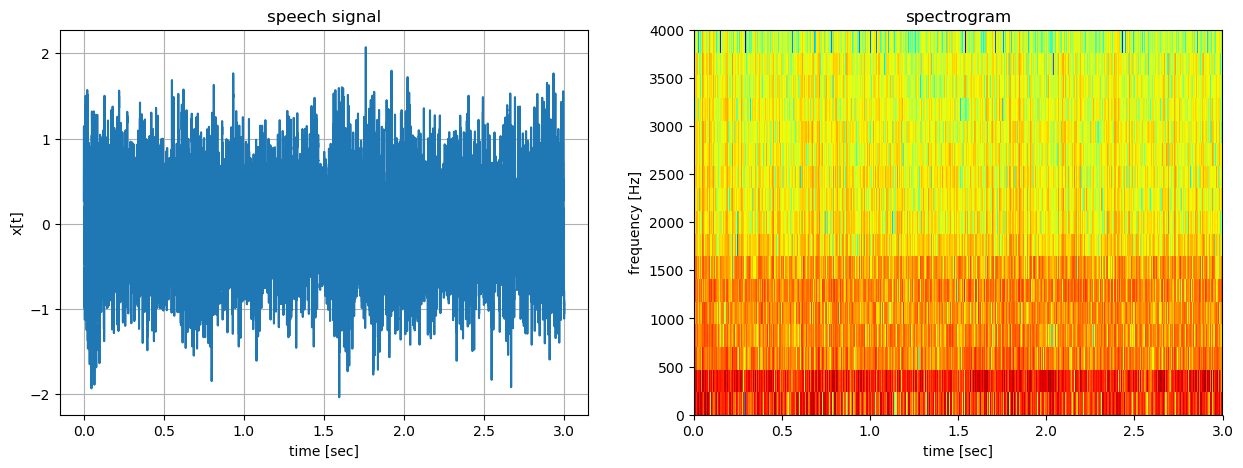

In [4]:
# create figure with subplots
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
ax[1].plot(t, x_time)

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(x_time, 32, 0, fs=fs_desired), fs_desired, ax=ax[2])

# visual modifications
ax[1].grid(), ax[1].set_ylabel("x[t]"), ax[1].set_xlabel("time [sec]"), ax[1].set_title("speech signal"), ax[2].set_title("spectrogram")
;

## Specify generative model

In [5]:
# create factor graph
fg = FactorGraph()

# placeholders
z_min = Array{Variable,1}(undef, 2*length(freq))
γ = Array{Variable,1}(undef, 2*length(freq))
θ = Array{Variable,1}(undef, 2*length(freq))
z = Array{Variable,1}(undef, 2*length(freq))

# specify observation noise
@RV v ~ GaussianMeanVariance(zeros(buffer_size), var_observation*Ic(buffer_size))

# specify previous hidden state (spectral component buffer)
for k = 1:2*length(freq)
    @RV [id=pad(:z_min,k)] z_min[k] ~ GaussianMeanVariance(placeholder(pad(:μ_z_min, k), dims = (AR_order,)),
                                        placeholder(pad(:Σ_z_min, k), dims = (AR_order, AR_order)))
    @RV [id=pad(:γ,k)] γ[k] ~ ForneyLab.Gamma(placeholder(pad(:a_γ,k)), placeholder(pad(:b_γ,k)))
    @RV [id=pad(:θ,k)] θ[k] ~ GaussianMeanVariance(placeholder(pad(:μ_θ,k), dims=(AR_order,)), placeholder(pad(:Σ_θ,k), dims=(AR_order, AR_order)))
    @RV [id=pad(:z,k)] z[k] ~ LAR.Autoregressive(θ[k], z_min[k], γ[k])
end

# specify Fourier matrix
Ceme1 = Array{Variable,1}(undef, 2*length(freq))
for k=1:2*length(freq)
    @RV Ceme1[k] 
    placeholder(Ceme1[k], pad(:Ceme1,k), dims = (buffer_size, AR_order))
end

# specify observations
@RV x = sum(Ceme1.*z)
@RV y = x + v

# create placeholder for observations
placeholder(y, :y, dims = (buffer_size,))

# draw factor graph
ForneyLab.draw(fg)
ForneyLab.draw(fg, external_viewer=:default)
;

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 15124812086238109641 -->
 15124812086238109641 
 
 placeholder_a_γ_27 
 
<!-- 5811542741705850879 -->
 5811542741705850879 
 
 placeholder_Σ_z_min_14 
 
<!-- 3699645357694532645 -->
 3699645357694532645 
 
 AR 
 autoregressive_1 
 
<!-- 322904424931803060 -->
 322904424931803060 
 
 Gam 
 gamma_1 
 
<!-- 3699645357694532645--322904424931803060 -->
 3699645357694532645--322904424931803060 
 
 γ_01 
 1 out 
 4 γ 
 
<!-- 17402524581215006381 -->
 17402524581215006381 
 
 𝒩 
 gaussianmeanvariance_3 
 
<!-- 3699645357694532645--17402524581215006381 -->
 3699645357694532645--17402524581215006381 
 
 θ_01 
 1 out 
 3 θ 
 
<!-- 12415077337139004993 -->
 12415077337139004993 
 
 𝒩 
 gaussianmeanvariance_2 
 
<!-- 3699645357694532645--12415077337139004993 -->
 3699645357694532645--12415077337139004993 
 
 z_min_01 
 1 out 
 2 x 
 
<!-- 194018975912190080 -->
 194018975912190080 
 
 Gam 
 gamma_7 
 
<!-- 16911103863244646053 -->
 16911103863244646053 
 
 placeholder_b_γ_07 
 
<!-- 194018975912190080--16911103863244646053 -->
 194018975912190080--16911103863244646053 
 
 b_γ_07 
 1 out 
 3 b 
 
<!-- 16565714687767538977 -->
 16565714687767538977 
 
 placeholder_a_γ_07 
 
<!-- 194018975912190080--16565714687767538977 -->
 194018975912190080--16565714687767538977 
 
 a_γ_07 
 1 out 
 2 a 
 
<!-- 11477143312631471241 -->
 11477143312631471241 
 
 placeholder_Σ_z_min_02 
 
<!-- 8601284435872211027 -->
 8601284435872211027 
 
 AR 
 autoregressive_18 
 
<!-- 3249938560487948591 -->
 3249938560487948591 
 
 𝒩 
 gaussianmeanvariance_36 
 
<!-- 8601284435872211027--3249938560487948591 -->
 8601284435872211027--3249938560487948591 
 
 z_min_18 
 1 out 
 2 x 
 
<!-- 13150374260868747714 -->
 13150374260868747714 
 
 𝒩 
 gaussianmeanvariance_37 
 
<!-- 8601284435872211027--13150374260868747714 -->
 8601284435872211027--13150374260868747714 
 
 θ_18 
 1 out 
 3 θ 
 
<!-- 13566964562398640026 -->
 13566964562398640026 
 
 Gam 
 gamma_18 
 
<!-- 8601284435872211027--13566964562398640026 -->
 8601284435872211027--13566964562398640026 
 
 γ_18 
 1 out 
 4 γ 
 
<!-- 7758410572933449654 -->
 7758410572933449654 
 
 𝒩 
 gaussianmeanvariance_1 
 
<!-- 968482447788860784 -->
 968482447788860784 
 
 clamp_1 
 
<!-- 7758410572933449654--968482447788860784 -->
 7758410572933449654--968482447788860784 
 
 clamp_1 
 1 out 
 2 m 
 
<!-- 14157249354665876657 -->
 14157249354665876657 
 
 clamp_2 
 
<!-- 7758410572933449654--14157249354665876657 -->
 7758410572933449654--14157249354665876657 
 
 clamp_2 
 1 out 
 3 v 
 
<!-- 4630346543327901857 -->
 4630346543327901857 
 
 𝒩 
 gaussianmeanvariance_58 
 
<!-- 2839856966309288248 -->
 2839856966309288248 
 
 placeholder_Σ_z_min_29 
 
<!-- 4630346543327901857--2839856966309288248 -->
 4630346543327901857--2839856966309288248 
 
 Σ_z_min_29 
 1 out 
 3 v 
 
<!-- 12082786942061871021 -->
 12082786942061871021 
 
 placeholder_μ_z_min_29 
 
<!-- 4630346543327901857--12082786942061871021 -->
 4630346543327901857--12082786942061871021 
 
 μ_z_min_29 
 1 out 
 2 m 
 
<!-- 8796725881238561446 -->
 8796725881238561446 
 
 AR 
 autoregressive_14 
 
<!-- 11612629230627436472 -->
 11612629230627436472 
 
 Gam 
 gamma_14 
 
<!-- 8796725881238561446--11612629230627436472 -->
 8796725881238561446--11612629230627436472 
 
 γ_14 
 1 out 
 4 γ 
 
<!-- 17715514760910431947 -->
 17715514760910431947 
 
 𝒩 
 gaussianmeanvariance_29 
 
<!-- 8796725881238561446--17715514760910431947 -->
 8796725881238561446--17715514760910431947 
 
 θ_14 
 1 out 
 3 θ 
 
<

In [6]:
# specify recognition factorization and create algorithm
q = RecognitionFactorization(θ, z, z_min, γ, ids=[:θ :z :z_min :γ])
algo = compatibility_fix(variationalAlgorithm(q))
# algo_F = freeEnergyAlgorithm(q) # throws error because the variables z are all connected

# evaluate algorithm
eval(Meta.parse(algo))
;

In [7]:
println(algo)

begin

function stepγ!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 60))

messages[1] = ruleVBGammaOut(nothing, ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:a_γ_30]), ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:b_γ_30]))
messages[2] = ruleVariationalARIn3PPPN(marginals[:z_30], marginals[:z_min_30], marginals[:θ_30], nothing)
messages[3] = ruleVBGammaOut(nothing, ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:a_γ_29]), ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:b_γ_29]))
messages[4] = ruleVariationalARIn3PPPN(marginals[:z_29], marginals[:z_min_29], marginals[:θ_29], nothing)
messages[5] = ruleVBGammaOut(nothing, ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:a_γ_28]), ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:b_γ_28]))
messages[6] = ruleVariationalARIn3PPPN(marginals[:z_28], marginals[:z_min_28], marginals[:θ_28], nothing)
messa

## Perform inference

In [ ]:
messages=Array{Message}(undef, 180)
data = Dict()
marginals = Dict()

# create placeholders for priors
μ_z_min = Array{Array{Float64,1},1}(undef, 2*length(freq))
Σ_z_min = Array{Array{Float64,2},1}(undef, 2*length(freq))
a_γ_min = Array{Float64,1}(undef, 2*length(freq))
b_γ_min = Array{Float64,1}(undef, 2*length(freq))
μ_θ_min = Array{Array{Float64,1},1}(undef, 2*length(freq))
Σ_θ_min = Array{Array{Float64,2},1}(undef, 2*length(freq))

# set priors 
for k = 1:2*length(freq)
    μ_z_min[k] = randn(AR_order)
    Σ_z_min[k] = 1e10*Ic(AR_order)
    a_γ_min[k] = 0.001
    b_γ_min[k] = 0.001
    μ_θ_min[k] = randn(AR_order)
    Σ_θ_min[k] = 1e0*Ic(AR_order)
end

# create marginals
for k = 1:2*length(freq)
    marginals[pad(:γ, k)] = ProbabilityDistribution(ForneyLab.Univariate, ForneyLab.Gamma, a=a_γ_min[k], b=b_γ_min[k])
    marginals[pad(:θ, k)] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=μ_θ_min[k], v=Σ_θ_min[k])
    marginals[pad(:z_min, k)] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=μ_z_min[k], v=Σ_z_min[k])
end

# initialize buffer
buf = BufferData(x_time, t, buffer_size)

# initialize placeholder for hidden states and observation
μ_x = Array{Float64,1}[]
Σ_x = Array{Float64,2}[]
μ_s = Array{Float64,1}[]
Σ_s = Array{Float64,2}[]

# create progress bar
p = Progress(len(buf, step_size), 1, "Observed ")

# loop through samples
for k = 1:len(buf, step_size)
        
    # update progress bar
    update!(p, k)
    
    # update data dictionary
    data[:y] = buf.buffer_s
    for f = 1:2*length(freq)
        data[pad(:Ceme1,f)] = calc_C(freq, buf.buffer_t)*em(2*length(freq), f)*(em(AR_order, 1)')
        data[pad(:a_γ, f)] = a_γ_min[f]
        data[pad(:b_γ, f)] = b_γ_min[f]
        data[pad(:μ_θ, f)] = μ_θ_min[f]
        data[pad(:Σ_θ, f)] = Σ_θ_min[f]
        data[pad(:μ_z_min, f)] = μ_z_min[f]
        data[pad(:Σ_z_min, f)] = Σ_z_min[f]
    end
    
    # run stepz! for prediction of x
    marginals = Base.invokelatest(stepz!, data, marginals, messages)  

    # get prediction of x
    push!(μ_x, ForneyLab.unsafeMean(messages[179].dist))
    push!(Σ_x, ForneyLab.unsafeCov(messages[179].dist))
    
    # infer parameters
    for it = 1:iterations
        
        # perform steps (z last to get prediction of x)
        marginals = Base.invokelatest(stepz!, data, marginals, messages)  
        marginals = Base.invokelatest(stepz_min!, data, marginals, messages)
        marginals = Base.invokelatest(stepγ!, data, marginals, messages)
        marginals = Base.invokelatest(stepθ!, data, marginals, messages)
        
    end
    
    # get spectral component values
    push!(μ_s, [ForneyLab.unsafeMean(marginals[pad(:z, k)])[1] for k=1:2*length(freq)])
    push!(Σ_s, diagm([ForneyLab.unsafeCov(marginals[pad(:z, k)])[1,1] for k=1:2*length(freq)]))
    
    # update hidden states
    for f = 1:2*length(freq)
        μ_z_min[f] = ForneyLab.unsafeMean(marginals[pad(:z,f)])
        Σ_z_min[f] = ForneyLab.unsafeCov(marginals[pad(:z,f)])
        a_γ_min[f] = marginals[pad(:γ,f)].params[:a]
        b_γ_min[f] = marginals[pad(:γ,f)].params[:b]
        μ_θ_min[f] = ForneyLab.unsafeMean(marginals[pad(:θ,f)])
        Σ_θ_min[f] = ForneyLab.unsafeCov(marginals[pad(:θ,f)])
    end
    
    # update buffer
    FLAG_data_remaining = step!(buf, step_size)
    
end

Observed   0%|█                                         |  ETA: 1:03:46

In [ ]:
# convert μ_x to a 1d array
#μ_x_pred = expand((hcat(μ_x...),dims=1))

# convert s_x to a 2d array
if length(size(μ_s)) != 2
    μ_s = hcat(μ_s...)
end

# calculate magnitude spectrum
mag_μ_s = log10.((μ_s[1:length(freq),:].^2 + μ_s[length(freq)+1:end,:].^2))


# create figure with subplots
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
cmp = ax[1].imshow(mag_μ_s,
                   aspect="auto",
                   cmap="jet",
                   origin="lower",
                   extent=[minimum(t), maximum(t), 1, length(freq)])
fig.colorbar(cmp, ax=ax[1])

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(x_time, 2*length(freq)+1, 0, fs=fs_desired), fs_desired, ax=ax[2], colorbar=true)

# change visuals
ax[1].set_xlim(minimum(t), maximum(t)), ax[2].set_ylim(minimum(freq), maximum(freq)), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("frequency [Hz]"), ax[1].set_title("Predicted spectrum"), ax[2].set_title("STFT spectrum")
#cmp.set_clim(-3, -16)
;

In [ ]:
# create figure with subplots
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

μ_x_pred_select = simplify(reverse(hcat(μ_x...), dims=1))
var_x_pred_select = expand([reverse(diag(Σ_x[k])) for k =1:length(Σ_x)])

# plot actual, noisy and marginal of frequency component
ax[1].plot(t, x_time, label="true"), ax[1].plot(t[1:length(μ_x_pred_select)], μ_x_pred_select, label="prediction")#, ax[1].plot(t[1:length(μ_x_pred_norm)], μ_x_pred_norm, label="normalized prediction")
ax[2].plot(t, x_time, label="true"), ax[2].plot(t[1:length(μ_x_pred_select)], μ_x_pred_select, label="prediction")#, ax[2].plot(t[1:length(μ_x_pred_norm)], μ_x_pred_norm, label="normalized prediction")
ax[2].fill_between(t[1:length(μ_x_pred_select)], μ_x_pred_select .- sqrt.(var_x_pred_select), μ_x_pred_select .+ sqrt.(var_x_pred_select), alpha=0.3, color="orange")

# change vizualization
ax[1].grid(), ax[1].set_xlim(0,3), ax[1].set_ylim(-1.5, 1.5), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("x[t]"), ax[1].legend()
ax[2].grid(), ax[2].set_xlim(1.2,1.21), ax[2].set_ylim(-1.5, 1.5), ax[2].set_xlabel("time [sec]"), ax[2].set_ylabel("x[t]"), ax[2].legend()

# create audioplayers
audioplayers(x_time, x_time_clean, μ_x_pred_select, fs=fs_desired)
;

## Performance metrics

In [ ]:
MSE = 1/length(μ_x_pred_select) * sum(abs.(μ_x_pred_select - x_time[1:length(μ_x_pred_select)]).^2)

In [ ]:
MAE = 1/length(μ_x_pred_select) * sum(abs.(μ_x_pred_select - x_time[1:length(μ_x_pred_select)]))

In [ ]:
using Distributions;
logBME = Float64[]
# initialize buffer
buf = BufferData(x_time, t, buffer_size)
for k = 1:length(μ_x)
    try 
        push!(logBME, sum([1/buffer_size*logpdf(Distributions.Normal(μ_x[k][ki], sqrt(Σ_x[k][ki,ki])), buf.buffer_s[ki]) for ki=1:buffer_size]))
    catch
    end
    step!(buf, step_size)
end
print("nr: "* string(length(logBME))* "       mean:"* string(mean(logBME)))